In [1]:
import logging
import os

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras import Sequential, Model
from tensorflow.keras.layers import Bidirectional, LSTM, Dense, Conv1D
from tensorflow.keras.optimizers import Adam

In [4]:
def normalize(values):
    max_value = np.max(values)
    min_value = np.min(values)
    #Normalizing between -1 and +1
    values = 2 * ((values - min_value) / (max_value - min_value)) - 1
    return (values)

def make_rolling_data(df, window_size=100, step_size=1):
    x = list()
    ext = window_size // 2 #extended window - ext
    for i in range(ext, df.shape[0]-ext-1, step_size):
        x.append(df.iloc[i-ext:i+ext].values)
    x = np.array(x)

    return (x)

def unroll_signal(x):
    x = np.array(x).reshape(100)
    return np.median(x)

def dtw_reconstruction_error(x, x_):
    #Other error metrics - point wise difference, Area difference.
    n, m = x.shape[0], x_.shape[0]
    dtw_matrix = np.zeros((n+1, m+1))
    for i in range(n+1):
        for j in range(m+1):
            dtw_matrix[i, j] = np.inf
    dtw_matrix[0, 0] = 0
    
    for i in range(1, n+1):
        for j in range(1, m+1):
            cost = abs(x[i-1] - x_[j-1])
            # take last min from a square box
            last_min = np.min([dtw_matrix[i-1, j], dtw_matrix[i, j-1], dtw_matrix[i-1, j-1]])
            dtw_matrix[i, j] = cost + last_min
    return dtw_matrix[n][m]

In [5]:
def make_generator(encoder_hidden_units = 100, decoder_hidden_unit=64):
        
    encoder = Sequential()
    encoder.add(Bidirectional(LSTM(encoder_hidden_units), input_shape=(100, 1)))
    encoder.add(Dense(20))
    
    decoder = Sequential()
    #In the below part, if return_sequences=False, it is not working. What does it do?
    decoder.add(Bidirectional(LSTM(decoder_hidden_unit, return_sequences=True), input_shape=(20, 1)))
    decoder.add(Bidirectional(LSTM(decoder_hidden_unit, dropout=0.4)))
    decoder.add(Dense(100))
    
    return encoder, decoder

def make_critic():
    critic_x =  Sequential()
    critic_x.add(Conv1D(filters=1, kernel_size=100, input_shape=(100, 1)))
    critic_x.add(Dense(units=1, activation='sigmoid'))
    
    critic_z =  Sequential()
    critic_z.add(Conv1D(filters=1, kernel_size=20, input_shape=(20, 1)))
    critic_z.add(Dense(units=1, activation='sigmoid'))
    
    return critic_x, critic_z

####  Preprocessing steps:

In [6]:
def wasserstein_loss(y_true, y_pred):
    """
    y_true = +1 for real data points
    y_true = -1 for generated data points
    """
    return K.mean(y_true * y_pred, axis=-1)

def random_weighted_average(x, x_):
    alpha = K.random_uniform((x.shape[0], 1, 1))
    return (alpha * x) + ((1 - alpha) * x_)

def train(n_epochs=2000):
    
    for epoch in range(n_epochs):
        n_critics = 5
        encoder.trainable = False
        decoder.trainable = False
        
        for i in range(n_critics):
            for x in dataset:
                critic_x.trainable = True
                critic_z.trainable = False    
                #Sampling z from random
                z = tf.random.uniform(shape=(x.shape[0], 20, 1), minval=-1, maxval=1, dtype=tf.float32, seed=10)
                with tf.GradientTape(persistent=True) as tape_cx:
                    #Critic score for real samples : When trained should be 1
                    valid_x = critic_x(x)
                    wl1 = wasserstein_loss(tf.ones_like(valid_x), valid_x)

                    #Generating critic score for noise samples : When trained should be 0
                    x_ = decoder(z)
                    x_ = tf.expand_dims(x_, axis=2)
                    fake_x = critic_x(x_)
                    wl2 = wasserstein_loss(-tf.ones_like(fake_x), fake_x)

                    #Calculating gradient penalty loss
                    x = tf.cast(x, tf.float32)
                    x_ = tf.cast(x, tf.float32)

                    ix = random_weighted_average(x, x_) #ix - interpolated_x
                    ix = tf.Variable(ix)
                    v_ix = critic_x(ix)

                    gradient = tape_cx.gradient(v_ix, ix)
                    gp_loss_x = K.sqrt(K.sum(K.batch_flatten(K.square(gradient)), axis=1, keepdims=True))-1

                    loss = wl1 + wl2 + gp_loss_x
                    loss = tf.reduce_mean(loss)
                    
                gradients = tape_cx.gradient(loss, critic_x.trainable_variables)
                critic_x_optim.apply_gradients(zip(gradients, critic_x.trainable_variables))
                loss_critic_x = loss
                
                critic_x.trainable = False
                critic_z.trainable = True
                with tf.GradientTape(persistent=True) as tape_cz:
                    valid_z = critic_z(z)
                    wl1 = wasserstein_loss(tf.ones_like(valid_z), valid_z)

                    z_ = encoder(x)
                    z_ = tf.expand_dims(z_, axis=2)
                    fake_z = critic_z(z_)
                    wl2 = wasserstein_loss(-tf.ones_like(fake_z), fake_z)

                    iz = random_weighted_average(z, z_)
                    iz = tf.Variable(iz)
                    v_iz = critic_z(iz)

                    gradient = tape_cz.gradient(v_iz, iz)
                    gp_loss_z = K.sqrt(K.sum(K.batch_flatten(K.square(gradient)), axis=1, keepdims=True))-1

                    loss = wl1 + wl2 + gp_loss_z
                    loss = tf.reduce_mean(loss)
                
                gradients = tape_cz.gradient(loss, critic_z.trainable_variables)
                critic_z_optim.apply_gradients(zip(gradients, critic_z.trainable_variables))
                loss_critic_z = loss
                
        critic_z.trainable = False
        critic_x.trainable = False
        encoder.trainable = True
        decoder.trainable = True
            
        for x in dataset:
            z = tf.random.uniform(shape=(x.shape[0], 20, 1), minval=-1, maxval=1, dtype=tf.float32, seed=10)

            with tf.GradientTape(persistent=True) as tape:
                valid_x = critic_x(x)
                wl1 = wasserstein_loss(tf.ones_like(valid_x), valid_x)

                x_ = decoder(z)
                x_ = tf.expand_dims(x_, axis=2)
                fake_x = critic_x(x_)
                wl2 = wasserstein_loss(-tf.ones_like(fake_x), fake_x)

                valid_z = critic_z(z)
                wl3 = wasserstein_loss(tf.ones_like(valid_z), valid_z)

                z_ = encoder(x)
                z_ = tf.expand_dims(z_, axis=2)
                fake_z = critic_z(z_)
                wl4 = wasserstein_loss(-tf.ones_like(fake_z), fake_z)

                enc_z = encoder(x)
                enc_z = tf.expand_dims(enc_z, axis=2)
                gen_x = decoder(enc_z)
                x = tf.squeeze(x)
                sqd_diff = tf.keras.losses.MSE(x, gen_x)
                loss = sqd_diff + wl1 + wl2 + wl3 + wl4
                loss = tf.reduce_mean(loss)
                
            grad_e = tape.gradient(loss, encoder.trainable_variables)
            grad_d = tape.gradient(loss, decoder.trainable_variables)
            enc_optim.apply_gradients(zip(grad_e, encoder.trainable_variables))
            dec_optim.apply_gradients(zip(grad_d, decoder.trainable_variables))
            enc_dec_loss = loss
        
        print ('Epoch {} critic x loss {} critic y loss {} enc-dec loss {}\n'.format(epoch, loss_critic_x, loss_critic_z, enc_dec_loss))
        if (epoch % 10 == 0):
            encoder.save('tadGan/Model/encoder.h5')
            decoder.save('tadGan/Model/decoder.h5')

            critic_x.save('tadGan/Model/critic_x.h5')
            critic_z.save('tadGan/Model/critic_z.h5')

In [ ]:
#from google.colab import drive
#drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#os.listdir('/content/drive/MyDrive/Data/realAdExchange')

['exchange-2_cpc_results.csv',
 'exchange-2_cpm_results.csv',
 'exchange-3_cpc_results.csv',
 'exchange-4_cpm_results.csv',
 'exchange-4_cpc_results.csv',
 'exchange-3_cpm_results.csv']

#### Dataset used:

We are using the signal from the file 'exxhange-2_cpm_results.csv'

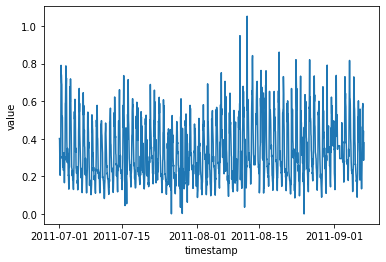

In [206]:
#data_dir = '/content/drive/MyDrive/Data/realAdExchange'
data_dir = 'realAdExchange'
files = os.listdir(data_dir)

for f in files:
    file_path = os.path.join(data_dir, f)
    df = pd.read_csv(file_path)
    #print (df.shape)
    #print (df.head(2))
    
df = pd.read_csv(os.path.join(data_dir, files[0]))
df = df.groupby('timestamp').agg('mean').reset_index()
df['timestamp'] = pd.to_datetime(df['timestamp'])
df = df.set_index('timestamp').resample('H').fillna('nearest')

sns.lineplot(x='timestamp', y='value', data=df)

#train: 70%, test: 30%

n = df.shape[0]
train_df = df[0:int(n*0.7)]
test_df = df[int(n*0.7):]

train_df = train_df.assign(value=normalize(train_df['value']))
test_df = test_df.assign(value=normalize(test_df['value']))

train_df = make_rolling_data(train_df)
test_df = make_rolling_data(test_df)

buffer_size = 1000
batch_size = 64
dataset = tf.data.Dataset.from_tensor_slices((train_df)).shuffle(buffer_size)
dataset = dataset.batch(batch_size)

test_dataset = tf.data.Dataset.from_tensor_slices((test_df))
#z = encoder(next(iter(dataset)))
#z = tf.reshape(z, (BATCH_SIZE, 20, 1))
#decoder(z)

In [9]:
#encoder, decoder = make_generator()
encoder = tf.keras.models.load_model('Model/encoder.h5')
decoder = tf.keras.models.load_model('Model/decoder.h5')

#critic_x, critic_z = make_critic()
critic_x = tf.keras.models.load_model('Model/critic_x.h5')
critic_z = tf.keras.models.load_model('M`odel/critic_z.h5')

critic_x_lr = 0.00005
critic_x_optim = Adam(lr=critic_x_lr)

critic_z_lr = 0.00005
critic_z_optim = Adam(lr=critic_z_lr)

enc_lr = 0.00005
enc_optim = Adam(lr=enc_lr)

dec_lr = 0.00005
dec_optim = Adam(lr=dec_lr)

In [ ]:
train(n_epochs=101)

Epoch 0 critic x loss -1.9999985694885254 critic y loss -1.9231698513031006 enc-dec loss -1.9601973295211792

Epoch 1 critic x loss -1.9999991655349731 critic y loss -1.9151523113250732 enc-dec loss -1.9613207578659058

Epoch 2 critic x loss -1.9999995231628418 critic y loss -1.9220185279846191 enc-dec loss -1.960364580154419

Epoch 3 critic x loss -1.9999996423721313 critic y loss -1.9351061582565308 enc-dec loss -1.963850498199463

Epoch 4 critic x loss -1.9999992847442627 critic y loss -1.9116320610046387 enc-dec loss -1.9634970426559448

Epoch 5 critic x loss -1.9999991655349731 critic y loss -1.9306763410568237 enc-dec loss -1.959904670715332

Epoch 6 critic x loss -1.999999761581421 critic y loss -1.9225364923477173 enc-dec loss -1.9629677534103394

Epoch 7 critic x loss -1.9999991655349731 critic y loss -1.901172399520874 enc-dec loss -1.9631576538085938

Epoch 8 critic x loss -1.9999996423721313 critic y loss -1.9102534055709839 enc-dec loss -1.9629077911376953

Epoch 9 critic 

Epoch 80 critic x loss -2.0 critic y loss -1.9384369850158691 enc-dec loss -1.9772523641586304

Epoch 81 critic x loss -1.999999761581421 critic y loss -1.901563286781311 enc-dec loss -1.9765900373458862

Epoch 82 critic x loss -2.0 critic y loss -1.927751898765564 enc-dec loss -1.9758551120758057

Epoch 83 critic x loss -2.0 critic y loss -1.9381341934204102 enc-dec loss -1.973544716835022

Epoch 84 critic x loss -2.0 critic y loss -1.9298067092895508 enc-dec loss -1.9758023023605347

Epoch 85 critic x loss -2.0 critic y loss -1.9327218532562256 enc-dec loss -1.974731683731079

Epoch 86 critic x loss -2.0 critic y loss -1.9190239906311035 enc-dec loss -1.976109266281128

Epoch 87 critic x loss -2.0 critic y loss -1.933591604232788 enc-dec loss -1.9764304161071777

Epoch 88 critic x loss -2.0 critic y loss -1.925358772277832 enc-dec loss -1.9785587787628174

Epoch 89 critic x loss -2.0 critic y loss -1.9450479745864868 enc-dec loss -1.9752116203308105

Epoch 90 critic x loss -2.0 criti

#### Plot for signal reconstructions:

Notes: Used for checking efficiency of mapping. We map original x and x_ (x after passing through encoder and decoder). (The two curves should be approximately same at all points which indicates training done well).

The signal is reconstructed in both train and test dataset.

In [58]:
df_r = df.copy()
df_r = df_r.assign(value=normalize(df_r['value']))

df_r = make_rolling_data(df_r)

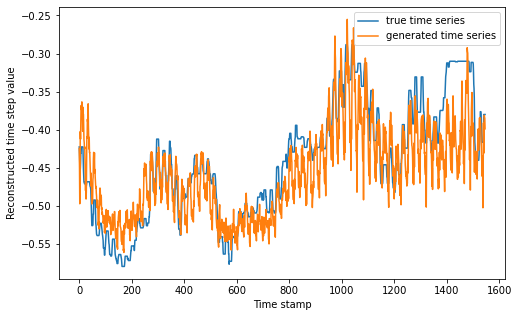

In [37]:
X = list()
X_ = list()

RE = list()  #Reconstruction error
CS = list()  #Critic score
for i in range(0, df_r.shape[0]):
    x = df_r[i]
    x = tf.reshape(x, (1, 100, 1))
    z = encoder(x)
    z = tf.expand_dims(z, axis=2)
    x_ = decoder(z)
    
    re = dtw_reconstruction_error(tf.squeeze(x_).numpy(), tf.squeeze(x).numpy()) #reconstruction error
    cs = critic_x(x)
    cs = tf.squeeze(cs).numpy()
    RE.append(re)
    CS.append(cs)
    
    x = unroll_signal(x)
    x_ = unroll_signal(x_)    
    
    X.append(x)
    X_.append(x_)

x = np.arange(len (X))
plt.figure(figsize=(8, 5))
plt.plot(x, X, label='true time series')
plt.plot(x, X_, label='generated time series')
plt.legend()
plt.xlabel('Time stamp')
plt.ylabel('Value')
plt.show()

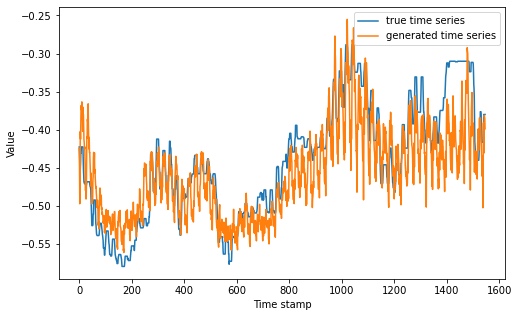

In [205]:
x = np.arange(len (X))
plt.figure(figsize=(8, 5))
plt.plot(x, X, label='true time series')
plt.plot(x, X_, label='generated time series')
plt.legend()
plt.xlabel('Time stamp')
plt.ylabel('Value')
plt.savefig('reconstructed_img.png')
plt.show()

Once we have found the reconstruction error and critic score, we calculate the anomaly score of the data points.

In [41]:
re = np.array(RE)
cs = np.array(CS)


re = (re - np.mean(re)) / np.std(re)
cs = (cs - np.mean(cs)) / np.std(cs)

alpha = 0.5
#alpha determines weightage
#anomaly_score = alpha * re + (1 - alpha) * cs
anomaly_scores = re * cs

In [203]:
import json

f = open('realAdExchange/combined_labels.json')

labels = json.load(f)

anomaly_timestamps = labels['realAdExchange/exchange-2_cpc_results.csv']

print ('Number of timestamps of anomaly data is ', len(anomaly_timestamps))

Number of timestamps of anomaly data is  1


In [201]:
#Making anomaly score and timestamp into a dataframe.

df['actual'] = 0
df['predicted'] = 0

ext = 100 // 2
index = list()
for i in range(ext, df.shape[0]-ext-1, 1):
    index.append(i)

#df = df.iloc[ext:df.shape[0]-ext-1].copy()

df = df.assign(anomaly_scores=anomaly_scores)

for i in anomaly_timestamps:
    i = pd.to_datetime(i) - pd.Timedelta(seconds=1)
    df.at[i, 'actual'] = 1

def label_anomaly(i, threshold = 0):
    if i > threshold:
        return 1
    return 0    

df.predicted = df.anomaly_scores.apply(label_anomaly)

true_positive = df[(df['actual'] == 1) & (df['predicted'] == 1)].shape[0]
false_positive = df[(df['actual'] == 0) & (df['predicted'] == 1)].shape[0]
true_negative = df[(df['actual'] == 0) & (df['predicted'] == 0)].shape[0]
false_negative = df[(df['actual'] == 1) & (df['predicted'] == 0)].shape[0]

precision = true_positive / (true_positive + false_positive)
recall = true_positive / (true_positive + false_negative)

f1 = 2 * precision * recall / (precision + recall)

print ('Precision {:.3f} Recall {}'.format(precision, recall))

Precision 0.001 Recall 1.0



### References:

https://github.com/signals-dev/Orion/blob/master/orion/primitives/tadgan.py

https://jleinonen.github.io/2019/11/07/gan-elements-2.html

https://medium.com/mit-data-to-ai-lab/time-series-anomaly-detection-in-the-era-of-deep-learning-f0237902224a

https://www.tensorflow.org/tutorials/generative/dcgan

https://github.com/soumith/ganhacks